In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import json
import os
import sys
import pickle

import ee
from geojson import Point, Feature, FeatureCollection, dump
import geopandas as gpd
from keplergl import KeplerGl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from tensorflow import keras


plastics_path = '/Users/ckruse/Documents/earthrise/plastics'
if plastics_path in sys.path:
    sys.path.remove('/Users/ckruse/Documents/earthrise/plastics')
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from scripts.get_s2_data_ee import get_history, get_history_polygon, get_pixel_vectors
from scripts import dl_utils
from scripts.viz_tools import normalize, plot_image_grid

In [110]:
import json
file_name = 'bolivar_2020_thresh_0.8postraining'
with open(os.path.join('../data/confirmed_sites', file_name + '.geojson'), 'r') as f:
    sites = json.load(f)['features']

mosaics, raster_info = dl_utils.download_mosaics(shapely.geometry.mapping(dl_utils.rect_from_point([-66.46272345, 5.62474032], 0.04)), '2020-05-01', '2020-11-01', 3, method='min')




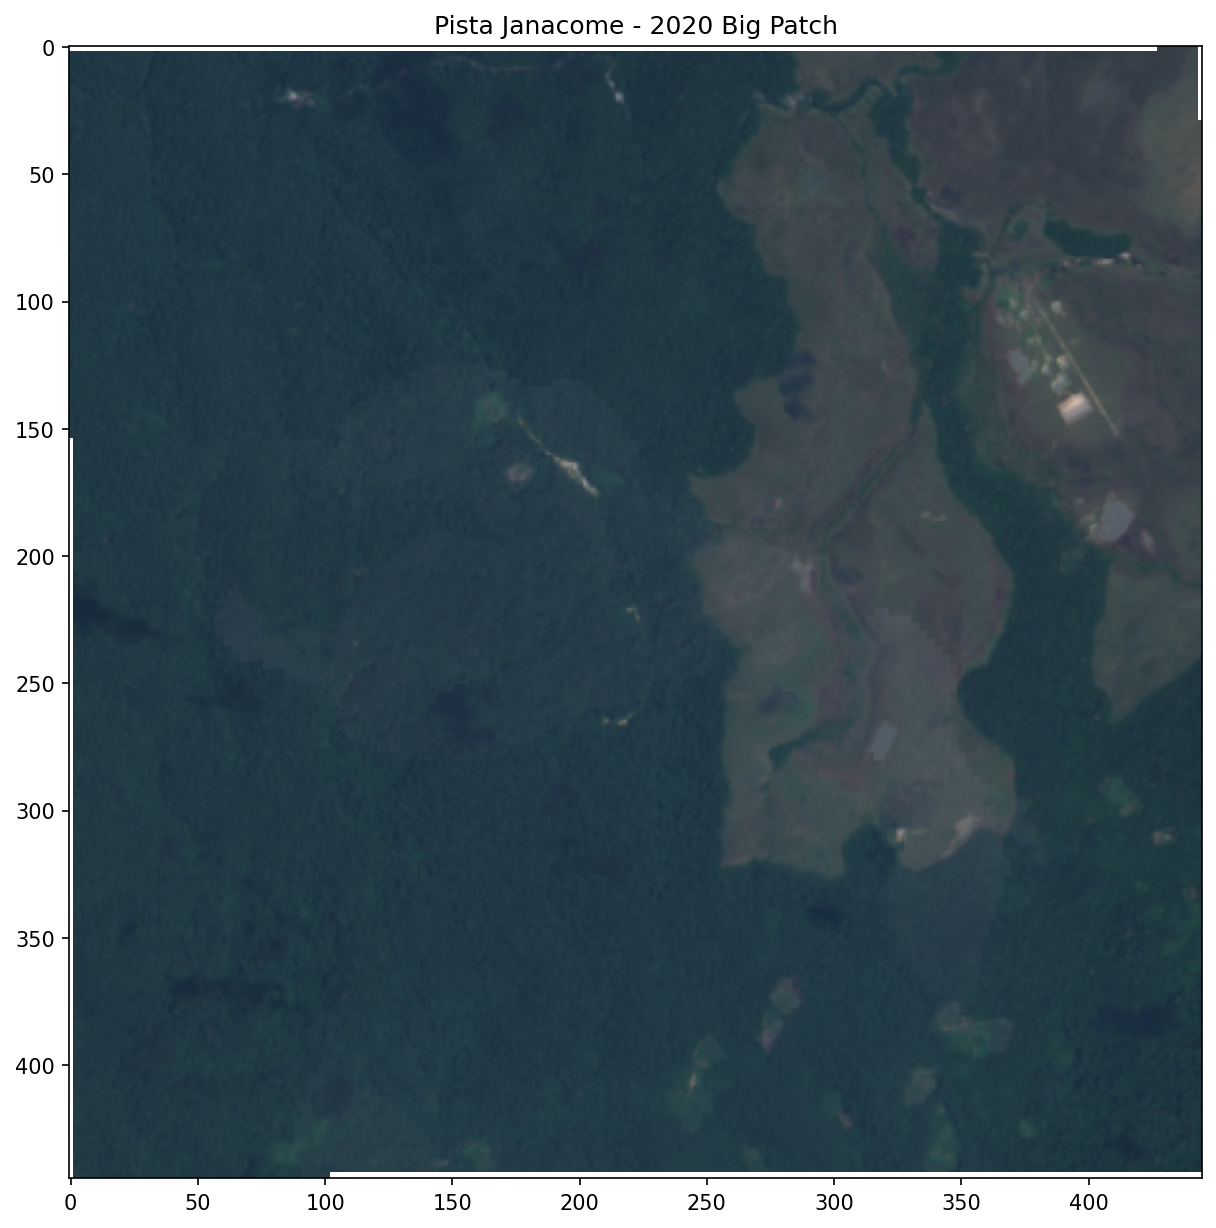

In [111]:
plt.figure(figsize=(10,10), dpi=150)
plt.imshow(mosaics[1][:,:,3:0:-1] / 3000)
plt.title('Pista Janacome - 2020 Big Patch')
plt.show()

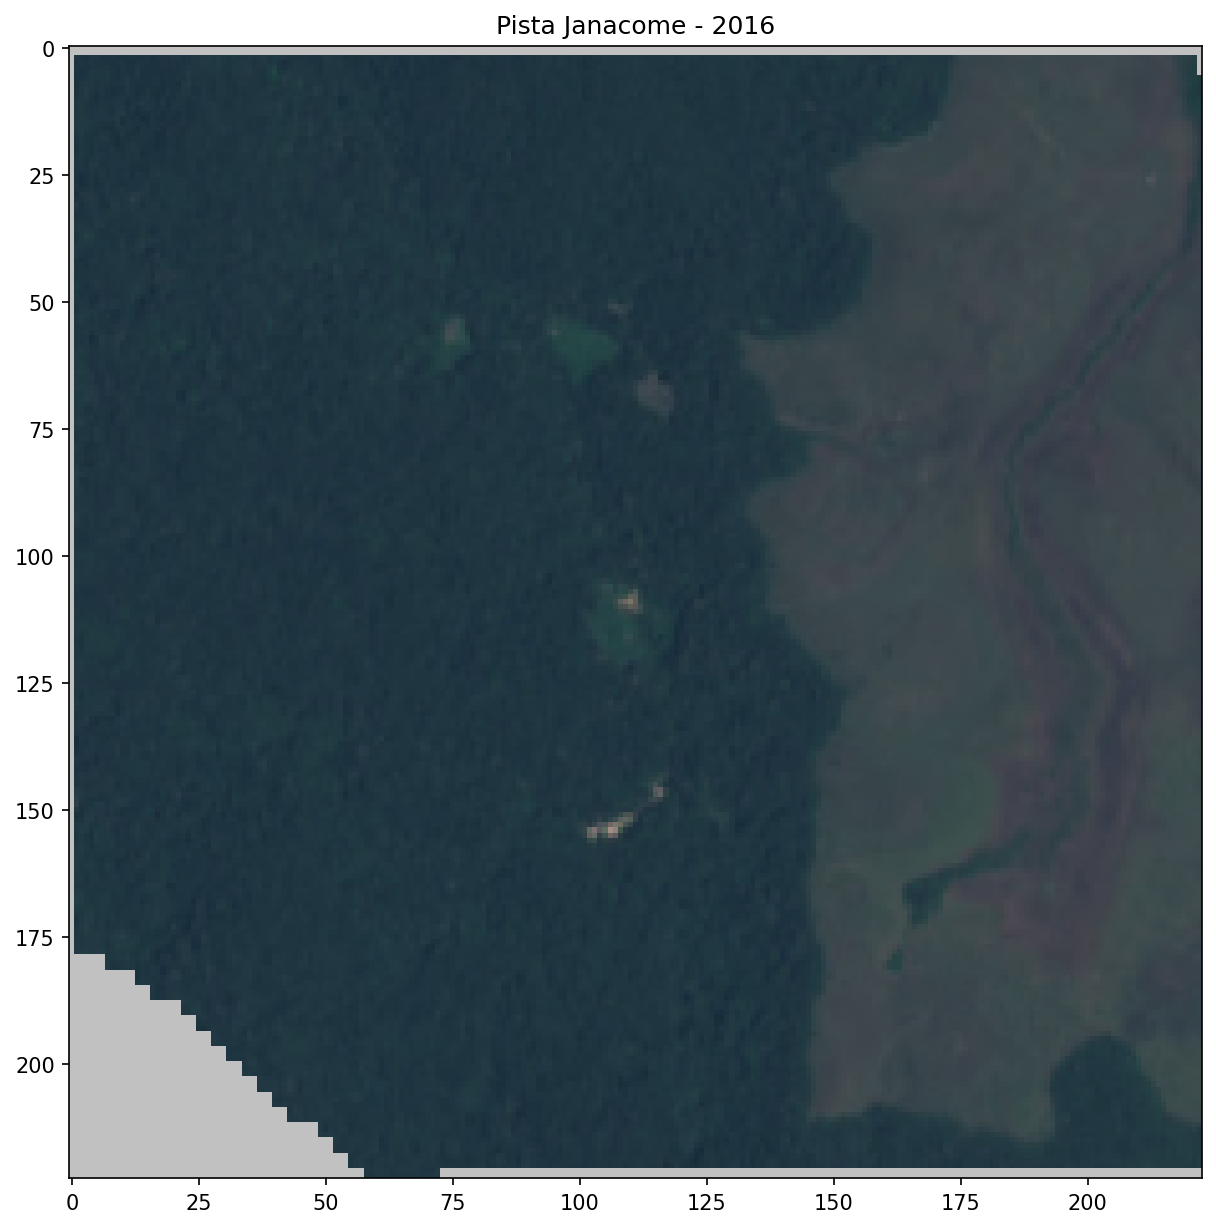

In [106]:
plt.figure(figsize=(10,10), dpi=150)
plt.imshow(mosaics[1][:,:,3:0:-1] / 3000)
plt.title('Pista Janacome - 2016')
plt.show()

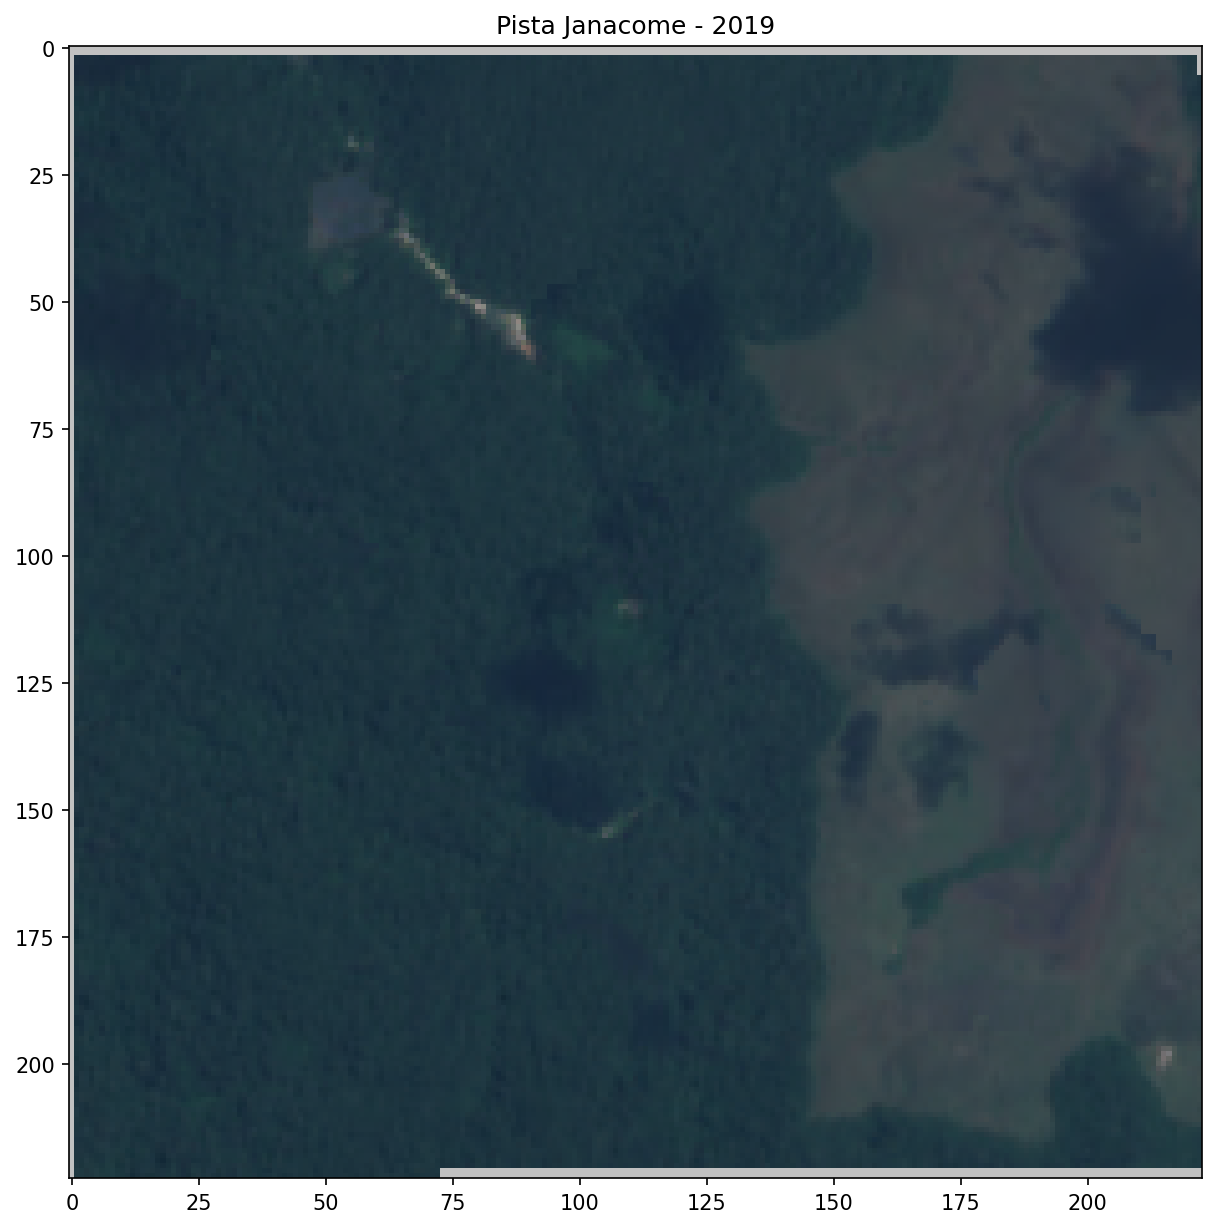

In [104]:
plt.figure(figsize=(10,10), dpi=150)
plt.imshow(mosaics[1][:,:,3:0:-1] / 3000)
plt.title('Pista Janacome - 2019')
plt.show()

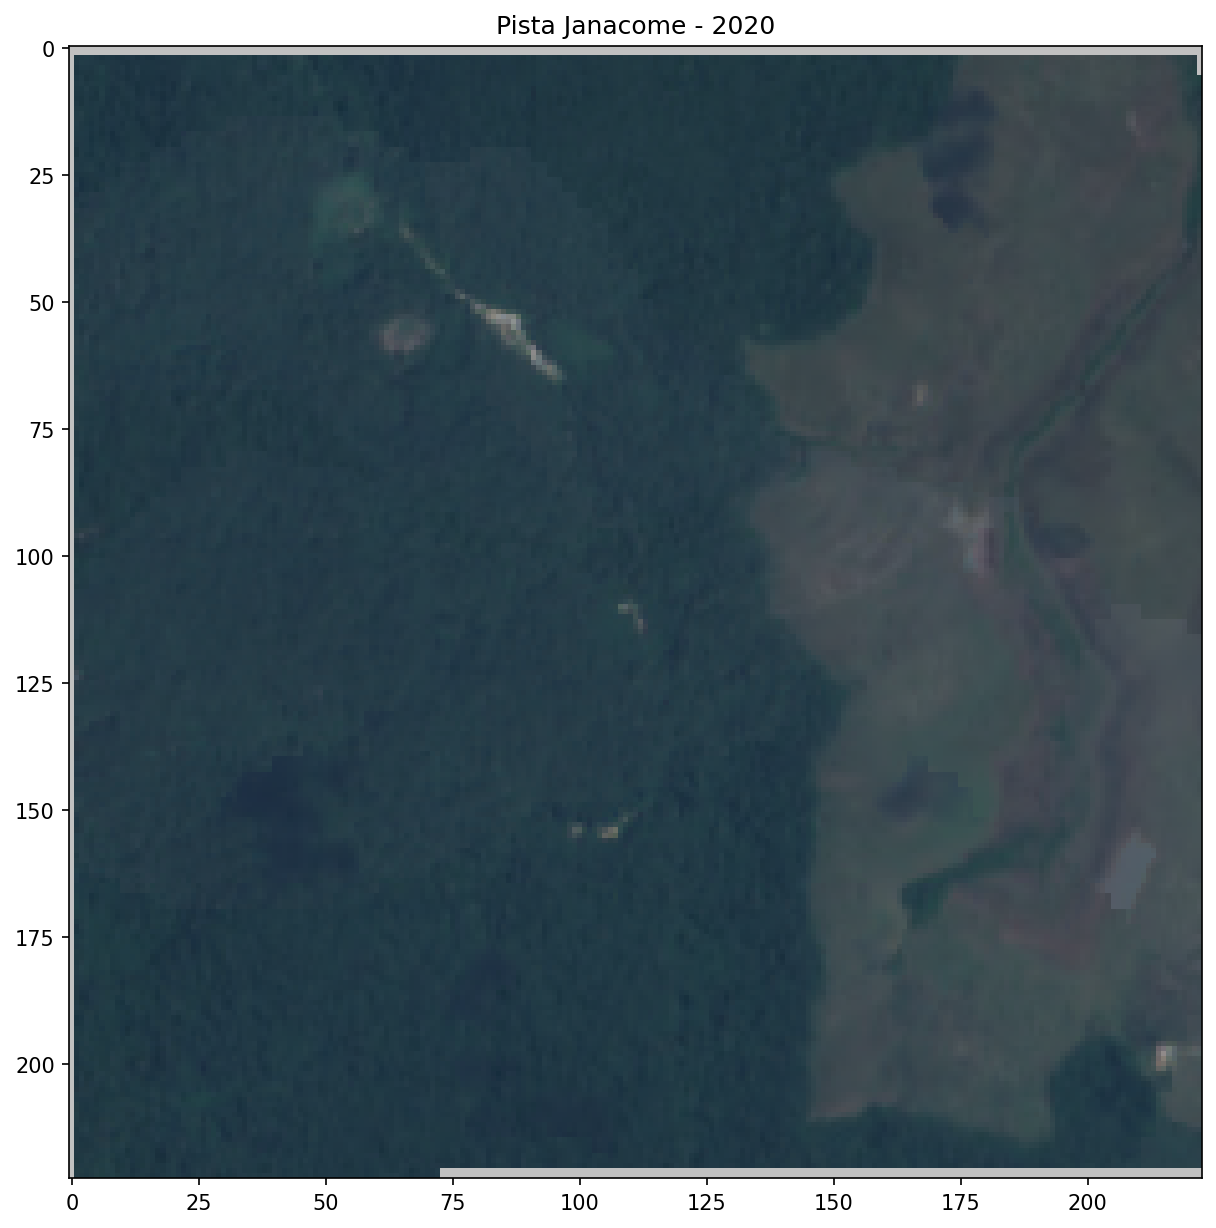

In [109]:
plt.figure(figsize=(10,10), dpi=150)
plt.imshow(mosaics[1][:,:,3:0:-1] / 3000)
plt.title('Pista Janacome - 2020')
plt.show()

In [8]:
def patches_from_tile(tile, raster_info, model):
    """
    Break a larger tile of Sentinel data into a set of patches that
    a model can process.
    Inputs:
        - tile: Sentinel data. Typically a numpy masked array
        - raster_info: Descartes metadata for the tile
        - model: keras model
    Outputs:
        - patches: A list of numpy arrays of the shape the model requires
        - patch_coords: A list of shapely polygon features describing the patch bounds
    """
    patch_coords = raster_info[0]['wgs84Extent']['coordinates'][0]
    delta_lon = patch_coords[2][0] - patch_coords[0][0]
    delta_lat = patch_coords[1][1] - patch_coords[0][1]
    top_left = patch_coords[0]
    
    # The tile is broken into the number of whole patches
    # Regions extending beyond will not be padded and processed
    _, model_l, model_w, _ = model.input_shape
    num_steps_lon = np.shape(tile)[0] // model_l
    num_steps_lat = np.shape(tile)[1] // model_w
    
    patch_coords = []
    patches = []
    for i in range(num_steps_lon):
        for j in range(num_steps_lat):
            patch = tile[j * model_l : model_l + j * model_l, 
                         i * model_w : model_l + i * model_w]
            patches.append(patch)
            
            nw_patch = [top_left[0] + i * delta_lon / num_steps_lon, 
                        top_left[1] + j * delta_lat / num_steps_lat]
            
            tile_geometry = [nw_patch,
                             [nw_patch[0], nw_patch[1] + delta_lat / num_steps_lat],
                             [nw_patch[0] + delta_lon / num_steps_lon, 
                              nw_patch[1] + delta_lat / num_steps_lat],
                             [nw_patch[0] + delta_lon / num_steps_lon, nw_patch[1]],
                             nw_patch
                            ]
            patch_coords.append(shapely.geometry.Polygon(tile_geometry))
            
    return patches, patch_coords 

In [50]:
feature_list = []
for coords, preds in zip(patch_coords, np.array(preds_stack).T):
    geometry = shapely.geometry.mapping(coords)
    properties = {
        'mean': np.mean(preds, axis=0),
        'median': np.median(preds, axis=0),
        'min': np.min(preds, axis=0),
        'max': np.max(preds, axis=0),
        'std': np.std(preds, axis=0),
    }
    feature_list.append(dl.vectors.Feature(geometry = geometry, properties = properties))

In [84]:
geometry

{'type': 'Polygon',
 'coordinates': (((-61.44406714285714, 6.1994316),
   (-61.44406714285714, 6.1965637),
   (-61.4411969, 6.1965637),
   (-61.4411969, 6.1994316),
   (-61.44406714285714, 6.1994316)),)}

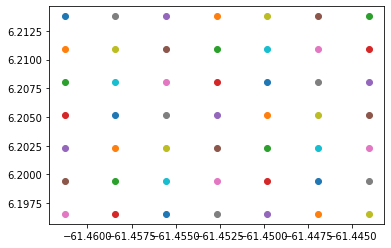

In [80]:
for coord in patch_coords:
    plt.scatter(coord.bounds[0], coord.bounds[1])
plt.show()

In [52]:
product = dl.vectors.FeatureCollection.create(product_id='ck_test',
                            title='ck_test',
                            description='ck_test')

In [97]:
raster_info

[{'driverShortName': 'MEM',
  'driverLongName': 'In Memory Raster',
  'files': [],
  'size': [223, 222],
  'coordinateSystem': {'wkt': 'PROJCS["WGS 84 / UTM zone 20N",\n    GEOGCS["WGS 84",\n        DATUM["WGS_1984",\n            SPHEROID["WGS 84",6378137,298.257223563,\n                AUTHORITY["EPSG","7030"]],\n            AUTHORITY["EPSG","6326"]],\n        PRIMEM["Greenwich",0,\n            AUTHORITY["EPSG","8901"]],\n        UNIT["degree",0.0174532925199433,\n            AUTHORITY["EPSG","9122"]],\n        AUTHORITY["EPSG","4326"]],\n    PROJECTION["Transverse_Mercator"],\n    PARAMETER["latitude_of_origin",0],\n    PARAMETER["central_meridian",-63],\n    PARAMETER["scale_factor",0.9996],\n    PARAMETER["false_easting",500000],\n    PARAMETER["false_northing",0],\n    UNIT["metre",1,\n        AUTHORITY["EPSG","9001"]],\n    AXIS["Easting",EAST],\n    AXIS["Northing",NORTH],\n    AUTHORITY["EPSG","32620"]]',
   'proj4': '+proj=utm +zone=20 +datum=WGS84 +units=m +no_defs '},
  'geo

In [81]:
model = keras.models.load_model('../models/28_px_v9.h5')
preds_stack = []
for tile in mosaics:
    patches, patch_coords = patches_from_tile(tile, raster_info, model)
    preds = model.predict(np.array(patches) / 3000)[:,1]
    preds_stack.append(preds)

pred_dict = {
    'mean': np.mean(preds_stack, axis=0),
    'median': np.median(preds_stack, axis=0),
    'min': np.min(preds_stack, axis=0),
    'max': np.max(preds_stack, axis=0),
    'std': np.std(preds_stack, axis=0),
    'geometry': patch_coords
}
gdf = gpd.GeoDataFrame(pred_dict)
pred_features = json.loads(gdf.to_json(drop_id=True))['features']
gdf

,mean,median,min,max,std,geometry
0,0.901547,0.901547,0.893664,0.909431,7.883519e-03,"POLYGON ((-61.46129 6.21664, -61.46129 6.21377..."
1,0.138876,0.138876,0.081090,0.196662,5.778616e-02,"POLYGON ((-61.46129 6.21377, -61.46129 6.21090..."
2,0.980875,0.980875,0.980584,0.981166,2.911985e-04,"POLYGON ((-61.46129 6.21090, -61.46129 6.20804..."
3,0.952730,0.952730,0.945330,0.960131,7.400393e-03,"POLYGON ((-61.46129 6.20804, -61.46129 6.20517..."
4,0.306560,0.306560,0.159896,0.453224,1.466638e-01,"POLYGON ((-61.46129 6.20517, -61.46129 6.20230..."
5,0.000002,0.000002,0.000002,0.000002,1.925555e-07,"POLYGON ((-61.46129 6.20230, -61.46129 6.19943..."
6,0.003990,0.003990,0.000484,0.007496,3.505772e-03,"POLYGON ((-61.46129 6.19943, -61.46129 6.19656..."
7,0.854264,0.854264,0.852486,0.856042,1.777530e-03,"POLYGON ((-61.45842 6.21664, -61.45842 6.21377..."
8,0.826276,0.826276,0.770000,0.882552,5.627644e-02,"POLYGON ((-61.45842 6.21377, -61.45842 6.21090..."
9,0.565207,0.565207,0.169410,0.961003,3.957964e-01,"POLYGON ((-61.45842 6.21090, -61.45842 6.20804..."


In [13]:
import descarteslabs as dl

In [28]:
fc_ids = [fc.id for fc in dl.vectors.FeatureCollection.list()]

In [33]:
product_id = 'test_region_v9.3_2019-06-01_2020-06-01_period_6_interval_2'
fc_ids = [fc.id for fc in dl.vectors.FeatureCollection.list()]
for fc in fc_ids:
    if product_id in fc:
        print("Found product", product_id)
        dl.vectors.FeatureCollection(fc).delete()

In [25]:
dl.vectors.FeatureCollection([fc.id for fc in dl.vectors.FeatureCollection.list() if 'test_region_v9.2' in fc.id][0])

IndexError: list index out of range

In [90]:
len([elem for elem in fc.limit(10000).features()])

0

In [96]:
product_id = [fc.id for fc in dl.vectors.FeatureCollection.list() if 'earthrise:test_region_v9_2019-06-01_2020-06-01_period_6_interval_2' in fc.id][0]
fc_id = [fc.id for fc in dl.vectors.FeatureCollection.list() if product_id in fc.id][0]
fc = dl.vectors.FeatureCollection(fc_id)
region = gpd.read_file(f'../data/bolivar_3.geojson')['geometry'][0]
    
features = []
for elem in fc.filter(region).features():
    features.append(elem.geojson)
results = gpd.GeoDataFrame.from_features(features)
print(len(results))
results.to_file(f"../data/outputs/{product_id}.geojson", driver='GeoJSON')

1922


In [ ]:
# make predictions

cloud_threshold = 0.1
_, model_l, model_w, _ = model.input_shape

preds_stack = []
for img in mosaics:
    patch = img / 3000
    # need to split the patch up into tiles of the width the model expects
    tiles = []
    for i in range(num_steps_lon):
        for j in range(num_steps_lat):
            tile = patch[j * model_l : model_l + j * model_l, 
                         i * model_w : model_l + i * model_w]
            tiles.append(tile)
    tile_pred = model.predict(np.array(tiles))
    #tile_pred = [np.sum(~tile.mask) / np.size(tile.mask) for tile in tiles]
    preds_stack.append(tile_pred)
    plt.figure(figsize=(10,10), dpi=150)
    for index, (tile, pred) in enumerate(zip(tiles, tile_pred)):
        plt.subplot(num_steps_lon, num_steps_lat, index + 1)
        #plt.imshow(tile[:,:,3:0:-1] / tile[:,:,3:0:-1].max())
        plt.imshow(np.clip(tile[:,:,3:0:-1] / 1.5, 0, 1))
        plt.axis('off')
        plt.title(f'{pred[1]:.2f}, {np.max(tile):.2f}')
    plt.tight_layout()
    plt.show()

pred_dict = {
    'mean': np.mean(preds_stack, axis=0),
    'median': np.median(preds_stack, axis=0),
    'min': np.min(preds_stack, axis=0),
    'max': np.max(preds_stack, axis=0),
    'std': np.std(preds_stack, axis=0),
}

In [ ]:
tile.shape

In [ ]:
for img in mosaics:
    print(img.shape)
    plt.imshow(np.clip(img[:,:,3:0:-1] / 3000, 0, 1))
    plt.axis('off')
    plt.show()

In [ ]:
dl_utils.rect_from_point()